In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision.datasets import CIFAR10
import torchvision.models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Rodando na {device} \nPyTorch version: {torch.__version__}")

Rodando na cuda 
PyTorch version: 2.5.1+cu118


In [2]:
cifar10_train = CIFAR10('caminho', train=True, download=True)
cifar10_test = CIFAR10('caminho', train=False, download=True)

Data_dir = './datasets/cifar10'

CATEGORIES = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']


Files already downloaded and verified
Files already downloaded and verified


#Visualizar o dataset

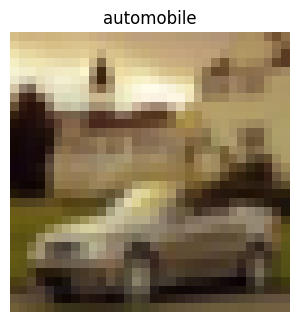

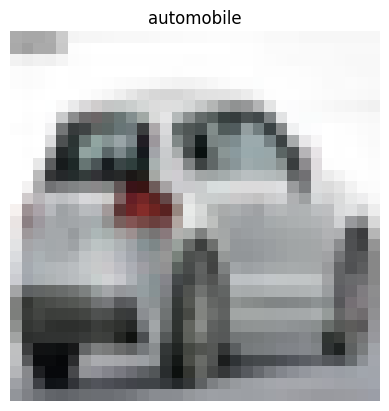

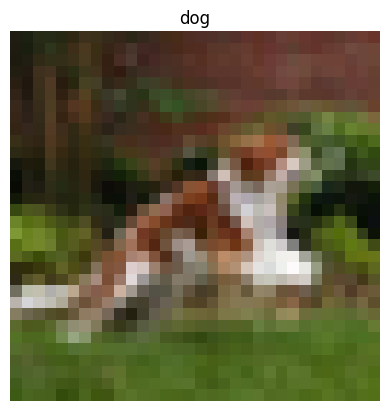

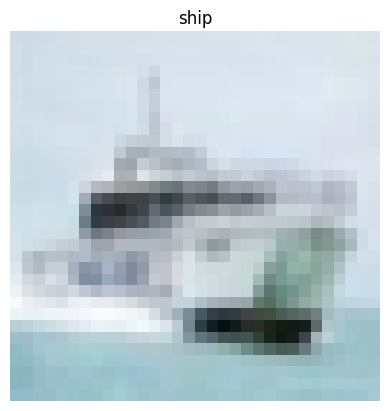

In [3]:
def look_dataset(dataset, istensor=False):
  figure = plt.figure(figsize=(8,8))
  rows, cols = 2,2
  for i in range(1,5):
    sample_idx = torch.randint(len(dataset), size=(1,)).item()
    img, label = dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(CATEGORIES[label])
    plt.axis("off")
    if istensor:
      plt.imshow(img.squeeze().permute(1,2,0))
    else:
      plt.imshow(img)
    plt.show()

look_dataset(cifar10_train)

#Convertendo o dataset para tensor


In [4]:
import torchvision.transforms as t

prep_transform = t.Compose(
    [
    t.Resize((299, 299)),
    t.ToTensor(),
    t.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225] )
    ]
)
#pytorch mandou usar normalize especifico para o inception_v3, usar? Sim
#mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]

tensor_train = CIFAR10('caminho', train=True, download=False, transform = prep_transform)
tensor_test = CIFAR10('caminho', train=False, download=False, transform = prep_transform)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9481792..1.9428324].


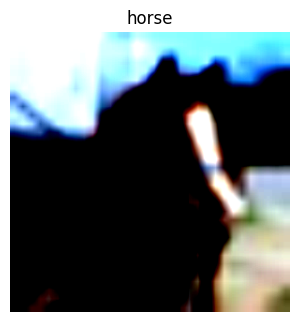

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0007002..1.8207895].


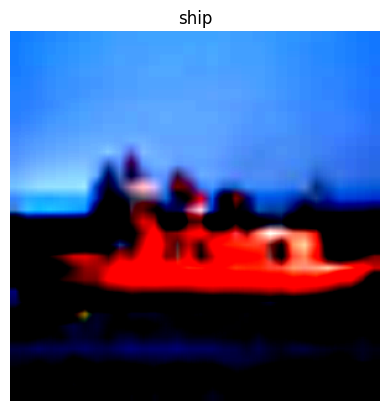

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3130406..2.64].


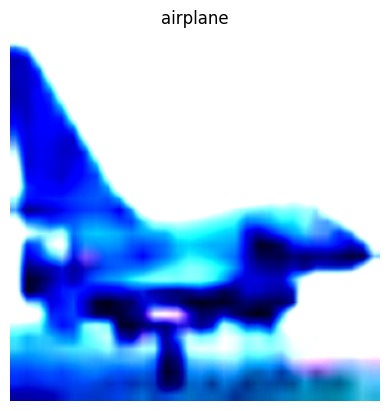

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.1345534].


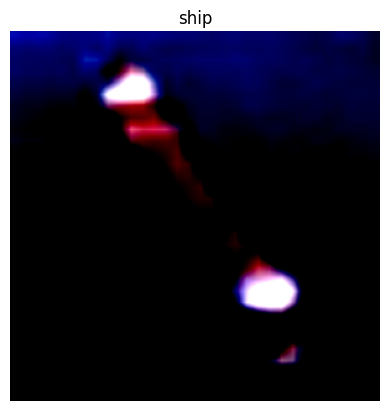

In [5]:
look_dataset(tensor_train, True)

#Trainamento da rede do zero


In [6]:
model_zero = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', weights=None, aux_logits=False).to(device)

Using cache found in /home/lucass/.cache/torch/hub/pytorch_vision_v0.10.0
/home/lucass/Área de Trabalho/test/venv/lib/python3.10/site-packages/torchvision/models/inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


#Rede pré-treinada sem Fine-Tuning

In [7]:

model_no_ft = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', weights='DEFAULT', aux_logits=True).to(device)
for param in model_no_ft.parameters():
    param.requires_grad = False  # Congelar as camadas

model_no_ft.fc = nn.Linear(model_no_ft.fc.in_features, 10).to(device)


Using cache found in /home/lucass/.cache/torch/hub/pytorch_vision_v0.10.0


#pré treinada com fine-Tuning

In [8]:
model_on_ft = torchvision.models.inception_v3(torchvision.models.Weights).to(device)
model_on_ft.fc = nn.Linear(model_on_ft.fc.in_features, 10).to(device)


/home/lucass/Área de Trabalho/test/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/home/lucass/Área de Trabalho/test/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
from torch.utils.data import DataLoader

batch_size = 64
train_loader = DataLoader(tensor_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(tensor_test, batch_size=batch_size, shuffle=False)

In [10]:
lossfunc = nn.CrossEntropyLoss()

optimizer_zero = torch.optim.SGD(model_zero.parameters(), lr=1e-3)

optimizer_noFT = torch.optim.SGD(model_no_ft.parameters(), lr=1e-3)

optimizer_FF = torch.optim.SGD(model_on_ft.parameters(), lr=1e-3)

#Treino da rede

In [12]:
def treino_modelo(modelo, otimizador, epocas):
    modelo.train()  # coloca o modelo em modo de treinamento
    history = {'train_loss': [], 'accuracy': [], 'precision': [], 'recall': [], 'f1_score': []}

    for epoch in range(epocas):
        running_loss = 0.0
        all_labels = []
        all_predictions = []

        # Loop de treino por batch
        for inputs, labels in tqdm(train_loader):
            otimizador.zero_grad()  # zera os gradientes acumulados
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = modelo(inputs)  # forward pass: obtem as predições

            if isinstance(outputs, torchvision.models.inception.InceptionOutputs):
                outputs = outputs.logits

            loss = lossfunc(outputs, labels)  # calcula a perda
            loss.backward()  # backward pass: calcula os gradientes
            otimizador.step()  # atualiza os pesos

            running_loss += loss.item()  # acumula a perda

            # Armazena os rótulos e predições para calcular métricas
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

        # Calcula a perda média na época
        epoch_loss = running_loss / len(train_loader)
        history['train_loss'].append(epoch_loss)

        # Calcula as métricas de acurácia, precisão, recall e F1-Score
        accuracy = accuracy_score(all_labels, all_predictions)
        precision = precision_score(all_labels, all_predictions, average='weighted')
        recall = recall_score(all_labels, all_predictions, average='weighted')
        f1 = f1_score(all_labels, all_predictions, average='weighted')

        # Armazena as métricas
        history['accuracy'].append(accuracy)
        history['precision'].append(precision)
        history['recall'].append(recall)
        history['f1_score'].append(f1)

        print(f'Epoch [{epoch + 1}/{epocas}] - Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}')

    return history

modelo do zero

In [12]:
treino_modelo(model_zero, optimizer_zero, 10)

100%|██████████| 782/782 [11:26<00:00,  1.14it/s]
/home/lucass/Área de Trabalho/test/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [1/10] - Loss: 4.9026, Accuracy: 0.1057, Precision: 0.1485, Recall: 0.1057, F1-Score: 0.1210


100%|██████████| 782/782 [10:06<00:00,  1.29it/s]
/home/lucass/Área de Trabalho/test/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [2/10] - Loss: 2.9729, Accuracy: 0.1781, Precision: 0.1787, Recall: 0.1781, F1-Score: 0.1783


100%|██████████| 782/782 [10:04<00:00,  1.29it/s]
/home/lucass/Área de Trabalho/test/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [3/10] - Loss: 2.7112, Accuracy: 0.2155, Precision: 0.2150, Recall: 0.2155, F1-Score: 0.2151


100%|██████████| 782/782 [10:05<00:00,  1.29it/s]
/home/lucass/Área de Trabalho/test/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [4/10] - Loss: 2.5304, Accuracy: 0.2376, Precision: 0.2364, Recall: 0.2376, F1-Score: 0.2368


100%|██████████| 782/782 [10:05<00:00,  1.29it/s]
/home/lucass/Área de Trabalho/test/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [5/10] - Loss: 2.4350, Accuracy: 0.2567, Precision: 0.2558, Recall: 0.2567, F1-Score: 0.2562


100%|██████████| 782/782 [10:05<00:00,  1.29it/s]


Epoch [6/10] - Loss: 2.3382, Accuracy: 0.2731, Precision: 0.2719, Recall: 0.2731, F1-Score: 0.2723


100%|██████████| 782/782 [10:04<00:00,  1.29it/s]
/home/lucass/Área de Trabalho/test/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [7/10] - Loss: 2.2797, Accuracy: 0.2838, Precision: 0.2822, Recall: 0.2838, F1-Score: 0.2828


100%|██████████| 782/782 [10:04<00:00,  1.29it/s]
/home/lucass/Área de Trabalho/test/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [8/10] - Loss: 2.2355, Accuracy: 0.2938, Precision: 0.2929, Recall: 0.2938, F1-Score: 0.2932


100%|██████████| 782/782 [10:08<00:00,  1.29it/s]
/home/lucass/Área de Trabalho/test/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [9/10] - Loss: 2.1651, Accuracy: 0.3071, Precision: 0.3055, Recall: 0.3071, F1-Score: 0.3061


100%|██████████| 782/782 [10:05<00:00,  1.29it/s]

Epoch [10/10] - Loss: 2.1238, Accuracy: 0.3157, Precision: 0.3139, Recall: 0.3157, F1-Score: 0.3146



/home/lucass/Área de Trabalho/test/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'train_loss': [4.902588197337392,
  2.9728522337306185,
  2.71117622590126,
  2.5304450798217597,
  2.4350406393370667,
  2.33819754425522,
  2.2797377315323675,
  2.2355074324571262,
  2.165089234366746,
  2.123836127083625],
 'accuracy': [0.10568,
  0.17812,
  0.21554,
  0.23764,
  0.25672,
  0.27314,
  0.28382,
  0.29382,
  0.30712,
  0.31568],
 'precision': [0.14847680625277776,
  0.17870590155922234,
  0.21498057952583857,
  0.236350353963932,
  0.2558490886482132,
  0.27185441273103383,
  0.2821963206757309,
  0.29290345964793746,
  0.30548691820818963,
  0.31388073044281],
 'recall': [0.10568,
  0.17812,
  0.21554,
  0.23764,
  0.25672,
  0.27314,
  0.28382,
  0.29382,
  0.30712,
  0.31568],
 'f1_score': [0.12097051778134287,
  0.17827615081843273,
  0.2151486585296184,
  0.23684528728339554,
  0.2561792181206556,
  0.2723309995261484,
  0.28279832779295266,
  0.2932387658876582,
  0.3061153368896127,
  0.3146093709369238]}

In [19]:
import os
import torch

# Obtém o diretório atual
diretorio_atual = os.getcwd()
print(f'Diretório atual: {diretorio_atual}')

# Obtém o diretório pai
diretorio_pai = os.path.dirname(diretorio_atual)
print(f'Diretório pai: {diretorio_pai}')

# Caminho para a pasta onde os pesos do modelo serão salvos
pasta_modelos = os.path.join(diretorio_pai, 'models_weights')
print(f'Caminho para a pasta de modelos: {pasta_modelos}')

# Verifica se o diretório existe, e se não, cria o diretório
if not os.path.exists(pasta_modelos):
    print(f'O diretório "{pasta_modelos}" não existe. Criando...')
    try:
        os.makedirs(pasta_modelos)
        print(f'Diretório "{pasta_modelos}" criado com sucesso!')
    except Exception as e:
        print(f'Erro ao criar o diretório: {e}')
else:
    print(f'O diretório "{pasta_modelos}" já existe.')

# Caminho completo para salvar o arquivo de pesos
caminho_pesos = os.path.join(pasta_modelos, 'inceptionV3.pth')
print(f'Caminho completo para o arquivo de pesos: {caminho_pesos}')

# Salva os pesos do modelo no arquivo
try:
    torch.save(model_zero.state_dict(), caminho_pesos)
    print(f'Pesos do modelo salvos com sucesso em: {caminho_pesos}')
except Exception as e:
    print(f'Erro ao salvar os pesos: {e}')


Diretório atual: /home/lucass/Área de Trabalho/test
Diretório pai: /home/lucass/Área de Trabalho
Caminho para a pasta de modelos: /home/lucass/Área de Trabalho/models_weights
O diretório "/home/lucass/Área de Trabalho/models_weights" já existe.
Caminho completo para o arquivo de pesos: /home/lucass/Área de Trabalho/models_weights/inceptionV3.pth
Pesos do modelo salvos com sucesso em: /home/lucass/Área de Trabalho/models_weights/inceptionV3.pth


modelo pré-treinado, sem fine-tuning

In [ ]:
treino_modelo(model_no_ft, optimizer_noFT , 10)

100%|██████████| 782/782 [06:21<00:00,  2.05it/s]


Epoch [1/10] - Loss: 2.0860, Accuracy: 0.3207, Precision: 0.3188, Recall: 0.3207, F1-Score: 0.3185


 72%|███████▏  | 566/782 [04:36<02:16,  1.58it/s]

modelo pré-treinado com fine-tuning

In [ ]:
treino_modelo(model_on_ft, optimizer_FF, 10)

In [ ]:
import seaborn as sns

def matriz_confusao_modelo(modelo, titulo_grafico, ax):
    # Inicializar listas para armazenar labels verdadeiros e previsões
    all_labels = []
    all_predictions = []

    # Avaliar o modelo e coletar as previsões
    with torch.no_grad():  # Desativa o cálculo de gradientes durante a avaliação
        for images, labels in tensor_test:
            outputs = modelo(images)
            _, predictions = torch.max(outputs, 1)

            all_labels.extend(labels.to(device).numpy())  # Coletar rótulos reais
            all_predictions.extend(predictions.to(device).numpy())  # Coletar previsões

    # Gerar matriz de confusão
    conf_matrix = confusion_matrix(all_labels, all_predictions)

    # Plotar a matriz de confusão
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', ax=ax, xticklabels=CATEGORIES, yticklabels=CATEGORIES)
    ax.set_xlabel('Previsão')
    ax.set_ylabel('Verdadeiro')
    ax.set_title('Matriz de Confusão - ' + titulo_grafico)

# Criar a figura e os subplots
fig, axs = plt.subplots(1, 3, figsize=(20, 6))  # 1 linha e 3 colunas

# Chamando a função para os três modelos treinados
matriz_confusao_modelo(model_zero, 'Modelo Treinado do Zero', axs[0])
matriz_confusao_modelo(model_no_ft, 'Modelo Sem Fine-Tuning', axs[1])
matriz_confusao_modelo(model_on_ft, 'Modelo Com Fine-Tuning', axs[2])

# Ajustar o layout dos gráficos para evitar sobreposição
plt.tight_layout()

# Mostrar os gráficos
plt.show()

In [ ]:
def plot_training_metrics(history_zero, history_no_ft, history_on_ft):
    plt.figure(figsize=(16, 12))

    # Plotando a Perda (Loss)
    plt.subplot(2, 2, 1)
    plt.plot(history_zero['train_loss'], color='blue', label='Treinado do Zero')
    plt.plot(history_no_ft['train_loss'], color='green', label='Sem Fine-tuning')
    plt.plot(history_on_ft['train_loss'], color='red', label='Com Fine-tuning')
    plt.title('Perda (Loss) durante o treinamento')
    plt.xlabel('Épocas')
    plt.ylabel('Perda')
    plt.legend()

    # Plotando a Acurácia
    plt.subplot(2, 2, 2)
    plt.plot(history_zero['accuracy'], color='blue', label='Treinado do Zero')
    plt.plot(history_no_ft['accuracy'], color='green', label='Sem Fine-tuning')
    plt.plot(history_on_ft['accuracy'], color='red', label='Com Fine-tuning')
    plt.title('Acurácia durante o treinamento')
    plt.xlabel('Épocas')
    plt.ylabel('Acurácia')
    plt.legend()

    # Plotando a Precisão (Precision)
    plt.subplot(2, 2, 3)
    plt.plot(history_zero['precision'], color='blue', label='Treinado do Zero')
    plt.plot(history_no_ft['precision'], color='green', label='Sem Fine-tuning')
    plt.plot(history_on_ft['precision'], color='red', label='Com Fine-tuning')
    plt.title('Precisão durante o treinamento')
    plt.xlabel('Épocas')
    plt.ylabel('Precisão')
    plt.legend()

    # Plotando o Recall
    plt.subplot(2, 2, 4)
    plt.plot(history_zero['recall'], color='blue', label='Treinado do Zero')
    plt.plot(history_no_ft['recall'], color='green', label='Sem Fine-tuning')
    plt.plot(history_on_ft['recall'], color='red', label='Com Fine-tuning')
    plt.title('Recall durante o treinamento')
    plt.xlabel('Épocas')
    plt.ylabel('Recall')
    plt.legend()

    # Ajuste o layout dos gráficos para evitar sobreposição
    plt.tight_layout()

    # Mostrar os gráficos
    plt.show()

# Chamando a função para plotar as métricas
plot_training_metrics(history_zero, history_no_ft, history_on_ft)